# Galaxy Redshift Estimitation
Author: Muhammad Fauzan Ishlah

#### Library and Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import astropy.io.fits as fits
from astropy.table import Table

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# data_url = 'https://anirut.space/data/decals_galaxy.fits' 
file = 'decals_galaxy.fits'
# hdul = fits.open(data_url) 
# data = hdul[1].data

dat = Table.read(file, format='fits')
df = dat.to_pandas()

#### Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368407 entries, 0 to 368406
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   RA      368407 non-null  float64
 1   DEC     368407 non-null  float64
 2   MAG_G   368407 non-null  float32
 3   MAG_R   368407 non-null  float32
 4   MAG_Z   368407 non-null  float32
 5   spec_z  368407 non-null  float32
dtypes: float32(4), float64(2)
memory usage: 11.2 MB


In [4]:
df.isnull().sum()

RA        0
DEC       0
MAG_G     0
MAG_R     0
MAG_Z     0
spec_z    0
dtype: int64

There is no missing data

In [5]:
df.loc[df['spec_z']<0, 'spec_z'].count()

0

There is no data with negative redshift. <br>
Therefore the data is already perfect for processing

#### Data Distribution

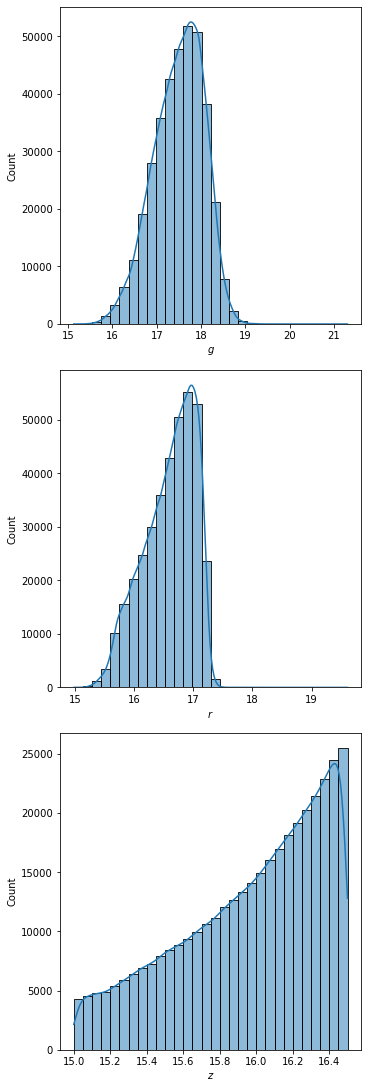

In [6]:
fig, ax = plt.subplots(3, figsize=(5,15), constrained_layout=True)
sns.histplot(
    data = df,
    x='MAG_G',
    bins = 30,
    kde = True,
    ax=ax[0]
)
ax[0].set_xlabel('$g$')

sns.histplot(
    data = df,
    x='MAG_R',
    bins = 30,
    kde = True,
    ax=ax[1]
)
ax[1].set_xlabel('$r$')

sns.histplot(
    data = df,
    x='MAG_Z',
    bins = 30,
    kde = True,
    ax=ax[2]
)
ax[2].set_xlabel('$z$')


plt.show()

##### Redshift distribution

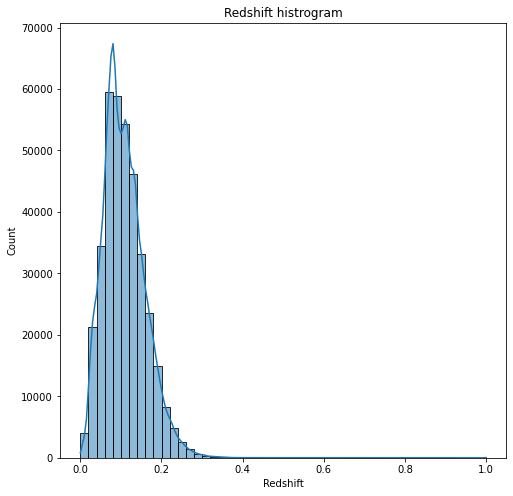

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(
    data = df,
    x='spec_z',
    bins = 50,
    kde = True,
    ax=ax
)
ax.set_xlabel('Redshift')
plt.title('Redshift histrogram')
plt.show()

##### Sky Coordinate

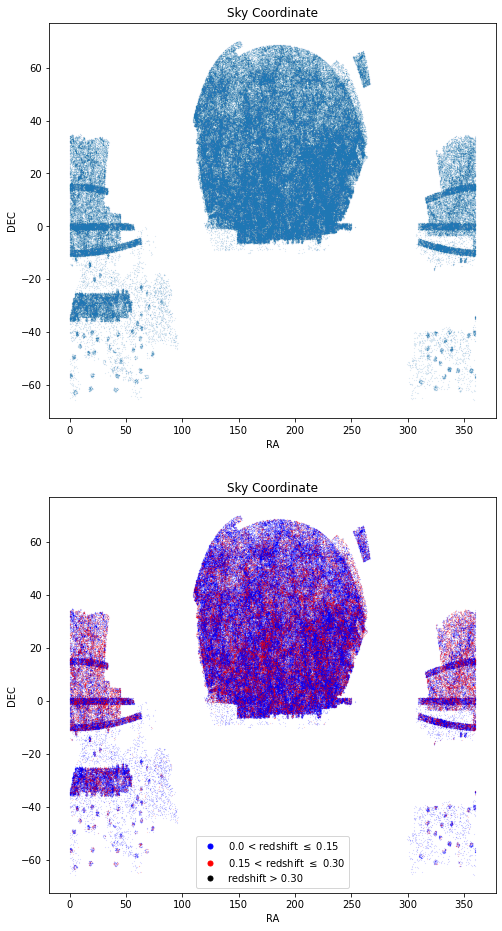

In [8]:
zs = df['spec_z']
cond1 = (zs > 0.0) & (zs <= 0.15)
cond2 = (zs > 0.15) & (zs <= 0.30)
cond3 = zs > 0.3

fig, ax= plt.subplots(2,figsize = (8,16))

ax[0].plot(df['RA'], df['DEC'], '.', markersize=0.1)
ax[0].set_xlabel("RA")
ax[0].set_ylabel("DEC")
ax[0].set_title('Sky Coordinate')

ax[1].plot(df['RA'][cond1], df['DEC'][cond1], 'b.', markersize=0.1, label="0.0 < redshift $\leq$ 0.15")
ax[1].plot(df['RA'][cond2], df['DEC'][cond2], 'r.', markersize=0.1, label="0.15 < redshift $\leq$ 0.30")
ax[1].plot(df['RA'][cond3], df['DEC'][cond3], 'k.', markersize=0.1, label="redshift > 0.30")
ax[1].set_xlabel("RA")
ax[1].set_ylabel("DEC")
ax[1].set_title('Sky Coordinate')
ax[1].legend(markerscale = 100)
plt.show()

#### Color relation diagram

In [9]:
gr = df['MAG_G'] - df['MAG_R']
rz = df['MAG_R'] - df['MAG_Z']
gz = df['MAG_G'] - df['MAG_Z']
df['gr'], df['rz'], df['gz'] = gr, rz, gz

##### $g - r$ vs $r  - z$

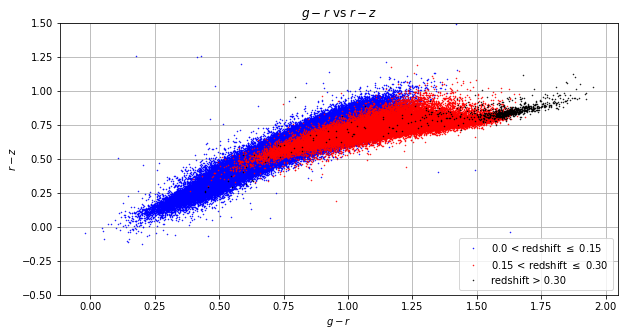

In [10]:
plt.figure(figsize=(10,5))
plt.plot(gr[cond1], rz[cond1], 'b.', 
         markersize=1, label="0.0 < redshift $\leq$ 0.15")
plt.plot(gr[cond2], rz[cond2], 'r.', 
         markersize=1, label="0.15 < redshift $\leq$ 0.30")
plt.plot(gr[cond3], rz[cond3], 'k.', 
         markersize=1, label="redshift > 0.30")
plt.ylim(-0.5, 1.5)
plt.xlabel("$g - r$")
plt.ylabel("$r - z$")
plt.title('$g-r$ vs $r-z$')
plt.legend(loc=4)
plt.grid()
plt.show()

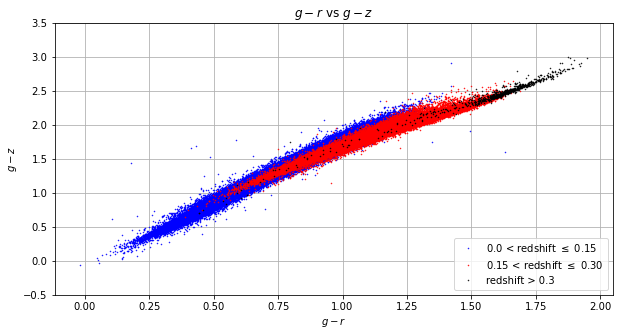

In [11]:
plt.figure(figsize=(10,5))
plt.plot(gr[cond1], gz[cond1], 'b.', 
         markersize=1, label="0.0 < redshift $\leq$ 0.15")
plt.plot(gr[cond2], gz[cond2], 'r.', 
         markersize=1, label="0.15 < redshift $\leq$ 0.30")
plt.plot(gr[cond3], gz[cond3], 'k.', 
         markersize=1, label="redshift > 0.3")
plt.ylim(-0.5, 3.5)
plt.xlabel("$g - r$")
plt.ylabel("$g - z$")
plt.title('$g-r$ vs $g-z$')
plt.grid()
plt.legend(loc=4)
plt.show()

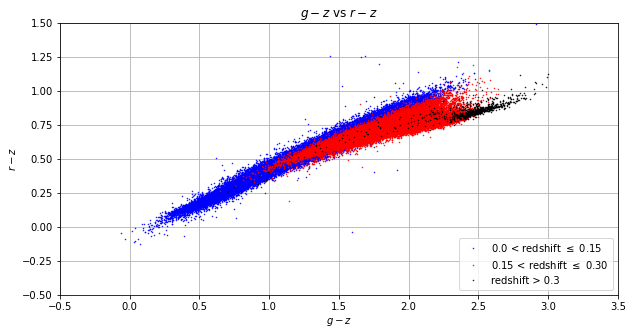

In [12]:
plt.figure(figsize=(10,5))
plt.plot(gz[cond1], rz[cond1], 'b.', 
         markersize=1, label="0.0 < redshift $\leq$ 0.15")
plt.plot(gz[cond2], rz[cond2], 'r.', 
         markersize=1, label="0.15 < redshift $\leq$ 0.30")
plt.plot(gz[cond3], rz[cond3], 'k.', 
         markersize=1, label="redshift > 0.3")
plt.ylim(-0.5, 1.5)
plt.xlim(-0.5, 3.5)
plt.xlabel("$g - z$")
plt.ylabel("$r - z$")
plt.title('$g-z$ vs $r-z$')
plt.grid()
plt.legend(loc=4)
plt.show()

### Features Selection

In here I use color band relation as the features to determine the redshift, where sky coordinate doesn't effect the redshift

In [13]:
features = ['MAG_G', 'MAG_R', 'MAG_Z', 'gr', 'rz', 'gz']
X = df.loc[:, features]
y = df.loc[:, 'spec_z']

#### Splitting the data

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

### Neural Network

#### Building the neural network layer

In [15]:
model = tf.keras.Sequential()
model.add(Dense(64, input_dim=6, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adadelta(0.01), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


#### Train the network

In [16]:
save_log = model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
4606/4606 [==============================] - 4s 858us/step - loss: 0.0027
Epoch 2/50
4606/4606 [==============================] - 4s 881us/step - loss: 0.0022
Epoch 3/50
4606/4606 [==============================] - 4s 904us/step - loss: 0.0020
Epoch 4/50
4606/4606 [==============================] - 4s 862us/step - loss: 0.0018
Epoch 5/50
4606/4606 [==============================] - 4s 788us/step - loss: 0.0016
Epoch 6/50
4606/4606 [==============================] - 4s 816us/step - loss: 0.0015
Epoch 7/50
4606/4606 [==============================] - 4s 819us/step - loss: 0.0014
Epoch 8/50
4606/4606 [==============================] - 4s 828us/step - loss: 0.0013
Epoch 9/50
4606/4606 [==============================] - 4s 815us/step - loss: 0.0012
Epoch 10/50
4606/4606 [==============================] - 4s 880us/step - loss: 0.0012
Epoch 11/50
4606/4606 [==============================] - 4s 871us/step - loss: 0.0012
Epoch 12/50
4606/4606 [==============================] - 4s 867

##### The loss per epoch

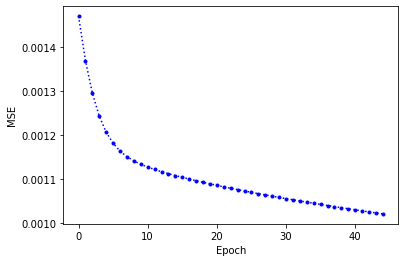

In [17]:
plt.plot(save_log.history['loss'][5:], "b.:")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

#### Testing the neural network
by predicting the redshift using the neural network

In [18]:
y_pred = model.predict(x_test)[:, 0]
sigma = np.std((np.abs(y_pred - y_test)) / (1.0 + y_test))
print("Standard Deviation = ", sigma)

Standard Deviation =  0.017061848952745373


##### Plot the predicted redshift vs actual redshift

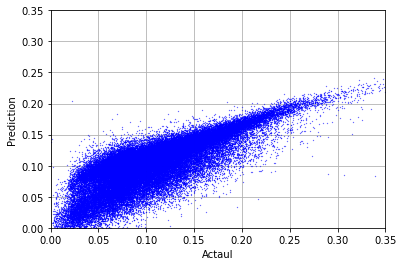

In [19]:
plt.xlim(0.0, 0.35)
plt.ylim(0.0, 0.35)
plt.plot(y_test, y_pred, 'b.', markersize = 0.5)
plt.xlabel("Actaul")
plt.ylabel("Prediction")
plt.grid()
plt.show()